# Setup and utils

In [1]:
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
import json
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from types import SimpleNamespace
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
from scipy.interpolate import griddata

# ------------------------------------ MODEL UTILS ----------------------------------------------
class CustomCNN(nn.Module):
    def __init__(self, input_dim, output_dim, depth, num_channels, hidden_dim_lin, activation_function, kernel_size, use_pooling=True):
        super(CustomCNN, self).__init__()

        # Initial number of input channels, assuming grayscale images
        in_channels = 1

        # Dynamically add convolutional and activation layers based on the specified depth
        for i in range(depth):
            # Create a convolutional layer and add it to the model
            setattr(self, f"conv{i}", nn.Conv2d(in_channels, num_channels, kernel_size=kernel_size, padding=1))

            # Create an activation layer (e.g., ReLU) and add it to the model
            setattr(self, f"act{i}", activation_function())

            # Update the input dimensions after convolution
            input_dim = (input_dim - kernel_size + 2 * 1) + 1

            # Optionally add pooling layers to reduce spatial dimensions
            if use_pooling and (i+1) % depth == 0:
                setattr(self, f"pool{i}", nn.MaxPool2d(2))
                input_dim = input_dim // 2

            # Update the input channels for the next convolutional layer
            in_channels = num_channels

        # Compute the size of the flattened features for the fully connected layer
        flattened_size = in_channels * input_dim * input_dim

        # Add two fully connected layers for classification
        self.fc_1 = nn.Linear(flattened_size, hidden_dim_lin)
        self.relu = activation_function()
        self.fc_2 = nn.Linear(hidden_dim_lin, output_dim)

        # Add log softmax layer for multi-class classification output
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
      # Iterate over each module in the CustomCNN class
      for layer_name, layer in self.named_children():
          # Process the input tensor through convolutional and activation layers
          if "conv" in layer_name or "act" in layer_name:
              x = layer(x)
          # Process the input tensor through pooling layers if they exist
          elif "pool" in layer_name:
              x = layer(x)
          # If reached fully connected layers, break the loop
          elif isinstance(layer, nn.Linear):
              break

      # Flatten the tensor to fit the input shape of the fully connected layers
      x = x.view(x.size(0), -1)

      # Pass the tensor through the fully connected layers
      x = self.fc_1(x)
      x = self.relu(x)
      x = self.fc_2(x)

      # Return log softmax activated output
      return self.logsoftmax(x)

def generate_cnn(input_dim, output_dim, depth, num_channels, hidden_dim_lin, kernel_size, activation_function=nn.ReLU, use_pooling=True):
    model = CustomCNN(input_dim, output_dim, depth, num_channels, hidden_dim_lin, activation_function, kernel_size, use_pooling)
    return model

class Trainer:
    """
    A class for training and evaluating a model with early stopping and best model saving functionalities.

    Attributes:
    - model: PyTorch model to be trained and evaluated.
    - dataloader: Contains data loaders (train, validation, test) for training and evaluation.
    - params: Dictionary containing various hyperparameters and settings.
    - device: the device to which tensors should be moved before computation.
    - optimizer: The optimizer for training.
    - best_model_state: State dictionary of the best model.
    - max_val_acc: The highest validation accuracy encountered during training.
    - no_improve_epochs: Number of epochs without improvement in validation accuracy.
    - is_cnn: Flag indicating if the model is a CNN.
    - is_debug: Flag indicating if debug information should be printed.
    - classification_report_flag: Flag indicating if a classification report should be generated.

    Methods:
    - train_epoch(): Runs a single epoch of training.
    - evaluate(loader): Evaluates the model on a given data loader.
    - save_best_model(): Saves the current state of the model as the best model.
    - save_checkpoint(epoch, train_acc, val_acc): Saves the current state of the model and other information as a checkpoint.
    - early_stopping_check(val_acc): Checks the stopping criterion and performs actions based on it.
    - train(): Runs the training process for a number of epochs, with early stopping functionality.

    Usage:
    params = {
      'device': 'cuda',
      'lr': 0.001,
      'num_train': 10,
      'early_stop_patience': 3,
      'save_best': True,
      'save_checkpoints': False,
      'is_cnn': True,
      'is_debug': True,
      'classification_report_flag': True
    }

    trainer = Trainer(model, dataloader, params)
    train_acc, test_acc, effective_epochs, checkpoints = trainer.train()
    """
    def __init__(self, model, dataloader, params):
        self.model = model
        self.dataloader = dataloader
        self.params = params
        self.device = torch.device(params['device'])
        self.optimizer = optim.Adam(model.parameters(), lr=params['lr'])
        # optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        # Initialize best_model_state with the current model state
        self.best_model_state = copy.deepcopy(self.model.state_dict())
        self.max_val_acc = 0.
        self.no_improve_epochs = 0
        self.is_cnn = params.get('is_cnn', False)
        self.is_debug = params.get('is_debug', False)
        self.classification_report_flag = params.get('classification_report_flag', False)
        self.logger = params.get('logger', print)

    def train_epoch(self):
      self.model.train()
      for batch_idx, (data, target) in enumerate(self.dataloader.train_loader):
          # Print the size of the current batch
          if self.is_cnn:
            data = data.view(data.size(0), 1, 28, 28)
          else:
            data = data.reshape([data.shape[0], -1])
          data, target = data.to(self.device), target.to(self.device)
          self.optimizer.zero_grad()
          output = self.model(data)
          loss = F.nll_loss(output, target)
          loss.backward()
          self.optimizer.step()

          if self.is_debug and batch_idx % 20 == 0:
              self.logger(f"Batch: {batch_idx}, Loss: {loss.item()}")

    def evaluate(self, loader):
        return eval(self.model, self.device, loader, self.is_debug, self.classification_report_flag, self.is_cnn)

    def save_best_model(self):
        torch.save(self.model.state_dict(), 'best_model.pth')

    def save_checkpoint(self, epoch, train_acc, val_acc):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_acc': train_acc,
            'val_acc': val_acc
        }
        torch.save(checkpoint, f'checkpoint_epoch_{epoch}.pth')
        return checkpoint

    def early_stopping_check(self, val_acc):
        if val_acc > self.max_val_acc:
            self.max_val_acc = val_acc
            self.no_improve_epochs = 0
            # Deep copy the model's state
            self.best_model_state = copy.deepcopy(self.model.state_dict())
            if self.params.get('save_best', False):
                self.save_best_model()
        else:
            self.no_improve_epochs += 1
            if self.no_improve_epochs >= self.params['early_stop_patience']:
                self.logger("Early stopping invoked.")
                # Only load if best_model_state has been set
                if self.best_model_state is not None:
                    self.model.load_state_dict(self.best_model_state)
                return True
        return False

    def train(self, verbose=1):
        effective_epochs = 0
        checkpoints = []

        for epoch in range(self.params['num_train']):
            effective_epochs += 1
            self.train_epoch()

            train_acc = self.evaluate(self.dataloader.train_loader)
            val_acc = self.evaluate(self.dataloader.val_loader)
            if verbose >= 1:
                self.logger(f'Epoch: {epoch} \tTraining Accuracy: {train_acc*100:.2f}%')
                self.logger(f'Validation Accuracy: {val_acc*100:.2f}%')

            if self.params.get('early_stop_patience', None):
                if self.early_stopping_check(val_acc):
                    self.model.load_state_dict(self.best_model_state)
                    break

            if self.params.get('save_checkpoints', False):
                checkpoint = self.save_checkpoint(epoch, train_acc, val_acc)
                checkpoints.append(checkpoint)

        # Final evaluations
        train_acc = self.evaluate(self.dataloader.train_loader)
        test_acc = self.evaluate(self.dataloader.test_loader)

        return train_acc, test_acc, effective_epochs, checkpoints

def eval(model, device, dataset_loader, debug=False, classification_report_flag=False, is_cnn=True, logger=print):
    """
    Evaluates the model on the given dataset loader.

    Parameters:
    - model: the PyTorch model to evaluate.
    - device: the device to which tensors should be moved before computation.
    - dataset_loader: DataLoader for evaluation.
    - debug: whether to print debug info like loss and accuracy.
    - classification_report_flag: whether to print a classification report.
    - is_cnn: a flag indicating if the model is a CNN. If it's not, the input data will be reshaped.
    - logger: logging function for printing messages.

    Returns:
    - Accuracy of the model on the provided dataset loader.

    Usage:
    - accuracy = eval(model, device, dataset_loader, debug=False, is_cnn=False, classification_report_flag=False)
    """

    model.eval()
    test_loss, correct = 0., 0.
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in dataset_loader:
            if is_cnn:
              data = data.view(data.size(0), 1, 28, 28)
            else:
              data = data.reshape([data.shape[0], -1])
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data

    if debug:
        logger('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, num_data, 100. * acc))

    if classification_report_flag:
        unique_labels = np.unique(all_labels).tolist()
        logger(classification_report(all_labels, all_preds, labels=unique_labels, target_names=[f'Class {i}' for i in unique_labels]))

    return acc

def cut_custom_cnn_model(model, cut_point, freeze=True, reinitialize=False):
    """
    Cut the CustomCNN model at a specific layer and reinitialize the weights for layers after cut_point.

    Parameters:
    - model (CustomCNN): Original CustomCNN model.
    - cut_point (int): Layer index (in terms of conv layers) at which to modify the model.
    - freeze (bool): If True, layers before cut_point will have their weights frozen.
    - reinitialize (bool): If True, layers after cut_point will have their weights reinitialized.

    Returns:
    - new_model (CustomCNN): Modified model.
    """

    new_model = copy.deepcopy(model)

    # Get names of layers in the model
    layer_names = list(new_model._modules.keys())

    # Find indices of Conv layers
    conv_indices = [i for i, name in enumerate(layer_names) if 'conv' in name]
    #print(conv_indices)

    # If freeze is True, set requires_grad to False for layers before cut_point
    if freeze:
        for idx in conv_indices[:cut_point]:
            for param in getattr(new_model, layer_names[idx]).parameters():
                param.requires_grad = False

    # Reinitialize layers after cut_point
    if reinitialize:
        for idx in conv_indices[cut_point:]:
            layer = getattr(new_model, layer_names[idx])
            nn.init.kaiming_uniform_(layer.weight, a=0, mode='fan_in', nonlinearity='relu')
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

    # reinit the final dense layer anyway
    new_model.fc_2.reset_parameters()

    # if reinit_both_dense: reinit the one before the last one too
    if params["reinit_both_dense"]:
        new_model.fc_1.reset_parameters()

    return new_model

# --------------------------------- DATA UTILS -----------------------------------
def reduce_dataset(dataloader, percentage, balanced=True, seed=42):

    """
    Reduces the dataset to the given percentage. Can ensure class balance if needed.

    Parameters:
    - dataloader: PyTorch DataLoader object.
    - percentage: Desired percentage of the original dataset.
    - balanced: If True, ensures class balance. If False, reduces randomly.
    - seed: Seed for reproducibility.

    Returns:
    - reduced_dataloader: DataLoader with the reduced dataset.
    """
    # Extract the dataset from the dataloader
    dataset = dataloader.dataset

    # Extract all data and labels from the dataset
    X = [dataset[i][0] for i in range(len(dataset))]
    y = [dataset[i][1] for i in range(len(dataset))]

    # Set the seed for reproducibility
    torch.manual_seed(seed)

    if not balanced:
        # Determine the number of samples to keep
        num_samples = int(len(dataset) * percentage)

        # Randomly select indices without replacement
        indices = torch.randperm(len(dataset))[:num_samples].tolist()

    else:
        # Get unique classes and their counts
        classes, class_counts = torch.unique(torch.tensor(y), return_counts=True)

        # Determine the number of samples per class to keep
        num_samples_per_class = int(len(dataset) * percentage / len(classes))
        indices = []

        for class_label in classes:
            class_indices = [i for i, label in enumerate(y) if label == class_label]

            # Randomly select indices without replacement for each class
            class_selected_indices = torch.randperm(len(class_indices))[:num_samples_per_class].tolist()
            indices.extend([class_indices[i] for i in class_selected_indices])

    # Use a Subset of the original dataset to create a reduced dataset
    reduced_dataset = data.Subset(dataset, indices)

    # Create a DataLoader with the reduced dataset.
    reduced_dataloader = data.DataLoader(reduced_dataset, batch_size=dataloader.batch_size, shuffle=True)

    return reduced_dataloader

class RelabeledSubset(torch.utils.data.Dataset):
    def __init__(self, dataset, offset):
        self.dataset = dataset
        self.offset = offset

    def __getitem__(self, idx):
        data, label = self.dataset[idx]
        # Offset the label to start from 0
        label = label - self.offset
        return data, label

    def __len__(self):
        return len(self.dataset)

class TransferLearningMNIST(object):
    def __init__(self, batch_size, input_dim=28*28, val_split=0.1, num_workers=0):
        self.input_dim = input_dim
        self.output_dim = 10
        self.val_split = val_split

        def filter_dataset(dataset, classes):
            indices = [i for i, t in enumerate(dataset.targets) if t in classes]
            return torch.utils.data.Subset(dataset, indices)

        mnist_train_data = datasets.MNIST(
            '../data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_train_data = filter_dataset(mnist_train_data, list(range(5)))
        finetune_train_data = filter_dataset(mnist_train_data, list(range(5, 10)))

        pretrain_len = len(pretrain_train_data)
        finetune_len = len(finetune_train_data)
        pretrain_val_len = int(val_split * pretrain_len)
        finetune_val_len = int(val_split * finetune_len)
        SEED = 42
        pretrain_train_set, pretrain_val_set = torch.utils.data.random_split(
            pretrain_train_data, [pretrain_len - pretrain_val_len, pretrain_val_len], generator=torch.Generator().manual_seed(SEED))
        finetune_train_set, finetune_val_set = torch.utils.data.random_split(
            finetune_train_data, [finetune_len - finetune_val_len, finetune_val_len], generator=torch.Generator().manual_seed(SEED))

        self.pretrain_train_loader = torch.utils.data.DataLoader(pretrain_train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        self.pretrain_val_loader = torch.utils.data.DataLoader(pretrain_val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        # Use the RelabeledSubset for fine-tuning datasets
        finetune_train_set = RelabeledSubset(finetune_train_set, 5)
        finetune_val_set = RelabeledSubset(finetune_val_set, 5)

        self.finetune_train_loader = torch.utils.data.DataLoader(finetune_train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        self.finetune_val_loader = torch.utils.data.DataLoader(finetune_val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        mnist_test_data = datasets.MNIST(
            '../data',
            train=False,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_test_data = filter_dataset(mnist_test_data, list(range(5)))
        finetune_test_data = filter_dataset(mnist_test_data, list(range(5, 10)))

        self.pretrain_test_loader = torch.utils.data.DataLoader(pretrain_test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        # Use the RelabeledSubset for fine-tuning test datasets
        finetune_test_data = RelabeledSubset(finetune_test_data, 5)
        self.finetune_test_loader = torch.utils.data.DataLoader(finetune_test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        # Complete test loader contains all test examples.
        self.complete_test_loader = torch.utils.data.DataLoader(mnist_test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

class TransferLearningMNISTWrapper:
    """
    This wrapper class provides a convenient way to switch between pretraining and fine-tuning phases.

    It allows for changing the phase and accordingly updating the data loaders (train, val, test)
    to either pretraining or fine-tuning sets.
    """
    def __init__(self, transferLearningMNISTObj, phase):
        """
        Initializes the TransferLearningMNISTWrapper object.

        Parameters:
        - transferLearningMNISTObj: An instance of the TransferLearningMNIST class.
        - phase: String indicating the current phase ("pretrain" or "finetune").
        """
        self.transferLearningMNISTObj = transferLearningMNISTObj
        self.phase = phase
        self.input_dim = self.transferLearningMNISTObj.input_dim
        self.output_dim = self.transferLearningMNISTObj.output_dim
        self.update_phase(phase)

    def update_phase(self, phase):
        """
        Updates the phase and the corresponding data loaders.

        Parameters:
        - phase: String indicating the desired phase ("pretrain" or "finetune").

        Throws:
        - ValueError: If the phase is neither "pretrain" nor "finetune".
        """
        self.phase = phase
        if phase == 'pretrain':
            self.train_loader = self.transferLearningMNISTObj.pretrain_train_loader
            self.val_loader = self.transferLearningMNISTObj.pretrain_val_loader
            self.test_loader = self.transferLearningMNISTObj.pretrain_test_loader
        elif phase == 'finetune':
            self.train_loader = self.transferLearningMNISTObj.finetune_train_loader
            self.val_loader = self.transferLearningMNISTObj.finetune_val_loader
            self.test_loader = self.transferLearningMNISTObj.finetune_test_loader
        else:
            raise ValueError('Phase must be either "pretrain" or "finetune".')

    def get_current_phase(self):
      return self.phase

# ------------------------------------------ PLOTTING UTILS -------------------------------------------
'''def effective_rank(singular_values):
    sigma_max = np.max(singular_values)
    sigma_min = singular_values[-1] if singular_values[-1] > 0 else np.min(singular_values[singular_values > 0])
    # print(sigma_max, sigma_min)
    print(np.sqrt(sigma_max / sigma_min))
    print('----')
    return np.sqrt(sigma_max / sigma_min)'''

def effective_rank(singular_values):
    normalized_singular_values = singular_values / np.sum(singular_values)
    entropy = -np.sum(normalized_singular_values * np.log(normalized_singular_values))
    eff_rank = np.exp(entropy)
    return eff_rank

def plot_layer_effective_ranks(model, print_ranks=True):
    effective_ranks = []
    layer_names = []

    for name, param in model.named_parameters():
        if 'weight' in name:  # We are only interested in weight matrices
            weight_matrix = param.detach().cpu().numpy()
            singular_values = np.linalg.svd(weight_matrix, compute_uv=False)
            eff_rank = effective_rank(singular_values)
            effective_ranks.append(eff_rank)
            layer_names.append(name)

    if print_ranks:
        for layer_name, eff_rank in zip(layer_names, effective_ranks):
            print(f'{layer_name}: {eff_rank:.4f}')

    # Plotting
    plt.figure(figsize=(15, 5))
    plt.bar(layer_names, effective_ranks, color='green')
    plt.xlabel('Layer')
    plt.ylabel('Effective Rank')
    plt.title('Effective Rank of Weight Matrices for Each Layer')
    plt.grid(True)

    y_max = np.max(effective_ranks) + 1  # Get maximum rank and add 1 for better visualization
    y_min = np.min(effective_ranks) - 1  # Get minimum rank and subtract 1 for better visualization
    plt.yticks(np.arange(0, int(y_max)+2, step=2))  # Set yticks

    plt.show()

#EXPERIMENT SETUP 1: _FREEZE, REINIT, POOLING, DENSE:REINIT BOTH_
- percentages_set_1 = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1]
- dataset: same as before MNIST 5 to 5

- architecture:
  - Conv 1 (5,5), channels=10
  - Relu
  - Conv 2 (5,5), channels=10
  - Relu
  - Conv 3 (5,5), channels=10
  - Relu
  - _POOLING_
  - Dense 1 (x, a) x=output shape of prev layer, a:random hidden layer width (we use 128)
  - Relu
  - Dense 2 (a, 5)
  - softmax

- lr pretraining = 0.001
- lr finetuning = 0.0001
- lr end-to-end = 0.001

- Freezing the layers before the cut: _YES_
- Reinitializing the Convolutional layers after the cut: _YES_
- Reinitializing Dense 1: _YES_
- Reinitializing Dense 2: _YES_


In [2]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps")
device

device(type='mps')

In [3]:
percentages = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1]

# cuts=0 means: end-to-end model if we are reinitializing
cuts = [0,1,2,3]
seed_set = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # currently not being used
repeats = 3
batch_size = 4096

## Pretraining



In [7]:
dataloader = TransferLearningMNIST(batch_size)
dataloader_wrapped = TransferLearningMNISTWrapper(dataloader, phase = 'pretrain')

# Changes Here for the experiments
params = {
      'depth': 3,
      'width': 10, # num channels for CNN
      'hidden_dim_lin': 128,
      'activation_function': nn.ReLU,
      'kernel_size': 5,
      'device': device,
      'lr': 0.001,
      'num_train': 20,
      'early_stop_patience': 6,
      'save_best': True,
      'save_checkpoints': True,
      'is_cnn': True,
      'is_debug': False,
      'classification_report_flag': False,
      'use_pooling': True,   # CHANGE
      'freeze': False,         # CHANGE: freeze the conv layers before the cut
      'reinit': True,         # CHANGE: reinit the conv lyers only after the cut
      'reinit_both_dense': True   # CHANGE: True for reinitialize both dense layers, False for reinit only the last dense layer
    }

# Create DNN model
pretrained_model = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
                     hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=params['use_pooling'])
pretrained_model.to(device)

CustomCNN(
  (conv0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=1210, out_features=128, bias=True)
  (relu): ReLU()
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

In [8]:
# Train and evaluate
trainer = Trainer(pretrained_model, dataloader_wrapped, params)
train_acc, test_acc, effective_epochs, checkpoints = trainer.train()

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")

Epoch: 0 	Training Accuracy: 20.04%
Validation Accuracy: 20.04%
Epoch: 1 	Training Accuracy: 49.84%
Validation Accuracy: 48.32%
Epoch: 2 	Training Accuracy: 85.09%
Validation Accuracy: 83.92%
Epoch: 3 	Training Accuracy: 89.44%
Validation Accuracy: 88.85%
Epoch: 4 	Training Accuracy: 92.22%
Validation Accuracy: 91.60%
Epoch: 5 	Training Accuracy: 93.67%
Validation Accuracy: 92.84%
Epoch: 6 	Training Accuracy: 94.60%
Validation Accuracy: 93.82%
Epoch: 7 	Training Accuracy: 95.32%
Validation Accuracy: 94.44%
Epoch: 8 	Training Accuracy: 95.68%
Validation Accuracy: 95.16%
Epoch: 9 	Training Accuracy: 96.16%
Validation Accuracy: 95.03%
Epoch: 10 	Training Accuracy: 96.51%
Validation Accuracy: 95.39%
Epoch: 11 	Training Accuracy: 96.58%
Validation Accuracy: 95.68%
Epoch: 12 	Training Accuracy: 96.78%
Validation Accuracy: 95.75%
Epoch: 13 	Training Accuracy: 97.06%
Validation Accuracy: 96.08%
Epoch: 14 	Training Accuracy: 97.21%
Validation Accuracy: 96.37%
Epoch: 15 	Training Accuracy: 97.17

conv0.weight: 38.9403
conv1.weight: 376.5502
conv2.weight: 379.8953
fc_1.weight: 117.6957
fc_2.weight: 9.8714


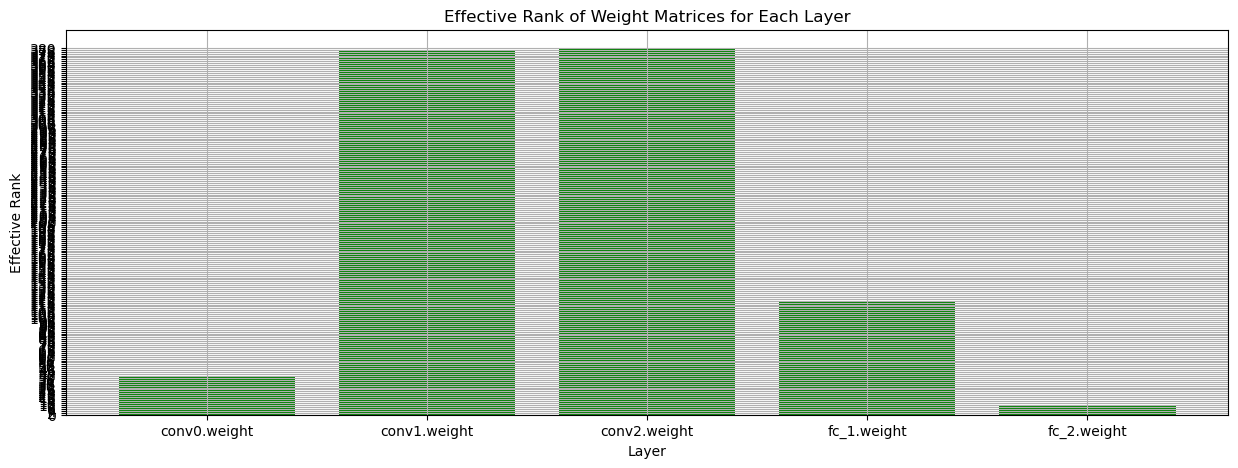

In [9]:
# Effective Rank of Pretrained model
plot_layer_effective_ranks(pretrained_model)  # Note: You'll need to define or load 'model' before calling this function


## Fine-tuning Experiments

In [10]:
params["lr"] = 0.0001
dataloader_wrapped.update_phase('finetune')

# Store results
results = []
# Store unique combinations that have been tested
tested_combinations = set()

for sampled_percentage in percentages:
    for sampled_cut_point in cuts:
        for repeat in range(repeats):
            # Add the combination to the tested set
            tested_combinations.add((sampled_percentage, sampled_cut_point))

            # Print or log the sampled values for transparency
            print(f"\nSampled Percentage: {sampled_percentage}, Sampled Cut Point: {sampled_cut_point}, Repeat: {repeat}")

            # Reduce the dataset
            train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed=random.randint(0, 100))
            dataset_namespace_new = SimpleNamespace(train_loader=train_loader_reduced, test_loader=dataloader_wrapped.test_loader, val_loader=dataloader_wrapped.val_loader)

            # Copy and then cut the model - we already deepcopy it in the function: pretrained_model
            model_new = cut_custom_cnn_model(pretrained_model, cut_point=sampled_cut_point, freeze=params["freeze"], reinitialize=params["reinit"])

            # Train and evaluate
            trainer = Trainer(model_new, dataset_namespace_new, params)
            train_acc, test_acc, effective_epochs, checkpoints = trainer.train(verbose=0)
            print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

            # Store the results
            results.append((sampled_percentage, sampled_cut_point, repeat, train_acc, test_acc))


Sampled Percentage: 0.001, Sampled Cut Point: 0, Repeat: 0
Training Accuracy: 0.8800, Test Accuracy: 0.5069

Sampled Percentage: 0.001, Sampled Cut Point: 0, Repeat: 1
Training Accuracy: 0.8000, Test Accuracy: 0.5009

Sampled Percentage: 0.001, Sampled Cut Point: 0, Repeat: 2
Training Accuracy: 0.7600, Test Accuracy: 0.4131

Sampled Percentage: 0.001, Sampled Cut Point: 1, Repeat: 0
Training Accuracy: 0.6400, Test Accuracy: 0.4522

Sampled Percentage: 0.001, Sampled Cut Point: 1, Repeat: 1
Early stopping invoked.
Training Accuracy: 0.7200, Test Accuracy: 0.4246

Sampled Percentage: 0.001, Sampled Cut Point: 1, Repeat: 2
Early stopping invoked.
Training Accuracy: 0.5600, Test Accuracy: 0.3874

Sampled Percentage: 0.001, Sampled Cut Point: 2, Repeat: 0
Training Accuracy: 0.8000, Test Accuracy: 0.6250

Sampled Percentage: 0.001, Sampled Cut Point: 2, Repeat: 1
Training Accuracy: 0.8800, Test Accuracy: 0.6813

Sampled Percentage: 0.001, Sampled Cut Point: 2, Repeat: 2
Training Accuracy: 0

In [11]:
#training of baseline, end to end, models (#trials x #percentages)

params["lr"] = 0.001 #back to training learning rate 
dataloader_wrapped.update_phase('finetune')


for sampled_percentage in percentages:
        for repeat in range(repeats):

            # Print or log the sampled values for transparency
            print(f"\nSampled Percentage: {sampled_percentage}, Sampled Cut Point: {-1}, Repeat: {repeat}")

            # Reduce the dataset
            train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed=random.randint(0, 100))
            dataset_namespace_new = SimpleNamespace(train_loader=train_loader_reduced, test_loader=dataloader_wrapped.test_loader, val_loader=dataloader_wrapped.val_loader)

            # Copy and then cut the model - we already deepcopy it in the function: pretrained_model
            model_temp = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
                     hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=params['use_pooling'])
            model_temp.to(device)

            # Train and evaluate
            trainer = Trainer(model_temp, dataset_namespace_new, params)
            train_acc, test_acc, effective_epochs, checkpoints = trainer.train(verbose=0)
            print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

            # Store the results
            results.append((sampled_percentage, -1, repeat, train_acc, test_acc)) # -1 for the cut point means it's baseline


Sampled Percentage: 0.001, Sampled Cut Point: -1, Repeat: 0
Training Accuracy: 0.9600, Test Accuracy: 0.7727

Sampled Percentage: 0.001, Sampled Cut Point: -1, Repeat: 1
Early stopping invoked.
Training Accuracy: 0.3200, Test Accuracy: 0.2421

Sampled Percentage: 0.001, Sampled Cut Point: -1, Repeat: 2
Training Accuracy: 0.8400, Test Accuracy: 0.6667

Sampled Percentage: 0.002, Sampled Cut Point: -1, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.3600, Test Accuracy: 0.3538

Sampled Percentage: 0.002, Sampled Cut Point: -1, Repeat: 1
Early stopping invoked.
Training Accuracy: 0.4000, Test Accuracy: 0.3419

Sampled Percentage: 0.002, Sampled Cut Point: -1, Repeat: 2
Early stopping invoked.
Training Accuracy: 0.2200, Test Accuracy: 0.2123

Sampled Percentage: 0.005, Sampled Cut Point: -1, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.2769, Test Accuracy: 0.2643

Sampled Percentage: 0.005, Sampled Cut Point: -1, Repeat: 1
Early stopping invoked.
Training Accuracy: 0.2000

### Print the results and save somewhere for future analysis

In [12]:
print(results)

[(0.001, 0, 0, 0.88, 0.5068915860933965), (0.001, 0, 1, 0.8, 0.5009257354453817), (0.001, 0, 2, 0.76, 0.41308372762806006), (0.001, 1, 0, 0.64, 0.4521703353219502), (0.001, 1, 1, 0.72, 0.42460399094836454), (0.001, 1, 2, 0.56, 0.3873688541452376), (0.001, 2, 0, 0.8, 0.6249742851265172), (0.001, 2, 1, 0.88, 0.681341287800864), (0.001, 2, 2, 0.44, 0.2908866488376877), (0.001, 3, 0, 0.96, 0.6356716724953714), (0.001, 3, 1, 0.96, 0.6745525612013988), (0.001, 3, 2, 0.96, 0.6889528903517794), (0.002, 0, 0, 0.3, 0.24603990948364535), (0.002, 0, 1, 0.8, 0.549681135568813), (0.002, 0, 2, 0.68, 0.5801275457724748), (0.002, 1, 0, 0.54, 0.41534663649454845), (0.002, 1, 1, 0.62, 0.485085373379963), (0.002, 1, 2, 0.6, 0.41390660357951037), (0.002, 2, 0, 0.76, 0.6313515737502572), (0.002, 2, 1, 0.78, 0.6741411232256738), (0.002, 2, 2, 0.84, 0.7220736473976548), (0.002, 3, 0, 0.9, 0.7893437564287183), (0.002, 3, 1, 0.9, 0.8070355893849003), (0.002, 3, 2, 0.84, 0.7784406500720017), (0.005, 0, 0, 0.2, 0

## Visualizations

### The Results Table and 3D plot (both go into the report)

In [13]:
# first of all convert results to df and calculate the mean and std of repats
repeats_mean = []
i = 0
for sampled_percentage in percentages:
    for sampled_cut_point in cuts:
        train, test = [], []
        for repeat in range(repeats):
            train.append(results[i][3])
            test.append(results[i][4])
            i += 1
        repeats_mean.append((sampled_percentage, sampled_cut_point, np.mean(train), np.std(train), np.mean(test), np.std(test)))
df = pd.DataFrame(repeats_mean, columns=['Percentage', 'Cut Point', 'Mean Train Accuracy', 'Std Train Accuracy', 'Mean Test Accuracy', 'Std Test Accuracy'])
df

,Percentage,Cut Point,Mean Train Accuracy,Std Train Accuracy,Mean Test Accuracy,Std Test Accuracy
0,0.001,0,0.813333,0.049889,0.473634,0.042885
1,0.001,1,0.640000,0.065320,0.421381,0.026553
2,0.001,2,0.706667,0.191369,0.532401,0.172320
3,0.001,3,0.960000,0.000000,0.666392,0.022504
4,0.002,0,0.593333,0.213125,0.458616,0.150827
5,0.002,1,0.586667,0.033993,0.438113,0.033220
6,0.002,2,0.793333,0.033993,0.675855,0.037057
7,0.002,3,0.880000,0.028284,0.791607,0.011783
8,0.005,0,0.535897,0.239191,0.489268,0.216219
9,0.005,1,0.497436,0.102114,0.436810,0.058934


In [14]:
# Create a 3D scatter plot
fig = px.scatter_3d(df,
                    x='Percentage',
                    y='Cut Point',
                    z='Mean Test Accuracy',  # or 'Train Accuracy' if you want to visualize training accuracy
                    color='Mean Test Accuracy',  # color scale based on test accuracy
                    size_max=18,
                    opacity=0.7)

# Set axis labels
fig.update_layout(scene=dict(xaxis_title='Percentage',
                             yaxis_title='Cut Point',
                             zaxis_title='Test Accuracy'))

fig.show()

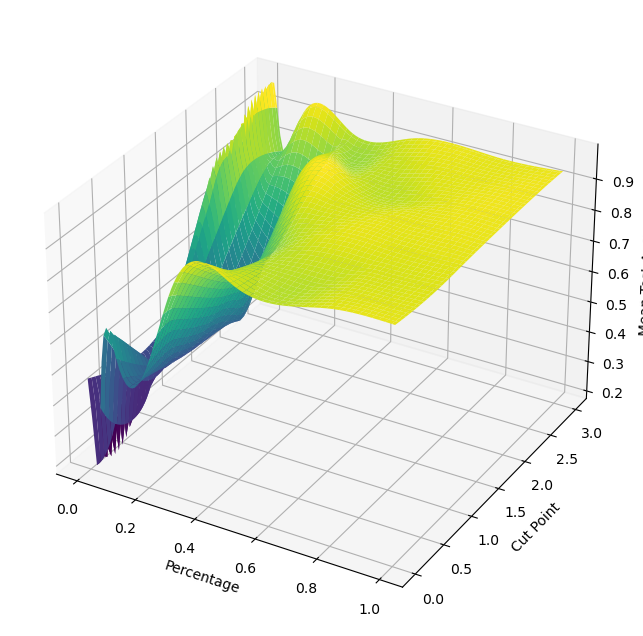

In [15]:
# Create grid values
xi = np.linspace(df['Percentage'].min(), df['Percentage'].max(), 100)
yi = np.linspace(df['Cut Point'].min(), df['Cut Point'].max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate
zi = griddata((df['Percentage'], df['Cut Point']), df['Mean Test Accuracy'], (xi, yi), method='cubic')

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xi, yi, zi, cmap='viridis')
ax.set_xlabel('Percentage')
ax.set_ylabel('Cut Point')
ax.set_zlabel('Mean Test Accuracy')
plt.show()

In [16]:
import pandas as pd

# Data provided by the user
data_tuples = results

# Define column names
columns = ['Percentage', 'Cut Point', 'Trial', 'Train Accuracy', 'Test Accuracy']

# Create DataFrame
df = pd.DataFrame(data_tuples, columns=columns)

# Calculate mean and standard deviation for test accuracies
# Assuming that the provided data has a pattern where every three tuples belong to the same
# percentage and cut point but different trials
df['Mean Train Accuracy'] = df.groupby(['Percentage', 'Cut Point'])['Train Accuracy'].transform('mean')
df['Mean Test Accuracy'] = df.groupby(['Percentage', 'Cut Point'])['Test Accuracy'].transform('mean')

# Now we display the DataFrame, though for brevity I'm only showing the first few rows here.
df.head()


,Percentage,Cut Point,Trial,Train Accuracy,Test Accuracy,Mean Train Accuracy,Mean Test Accuracy
0,0.001,0,0,0.88,0.506892,0.813333,0.473634
1,0.001,0,1,0.80,0.500926,0.813333,0.473634
2,0.001,0,2,0.76,0.413084,0.813333,0.473634
3,0.001,1,0,0.64,0.452170,0.640000,0.421381
4,0.001,1,1,0.72,0.424604,0.640000,0.421381


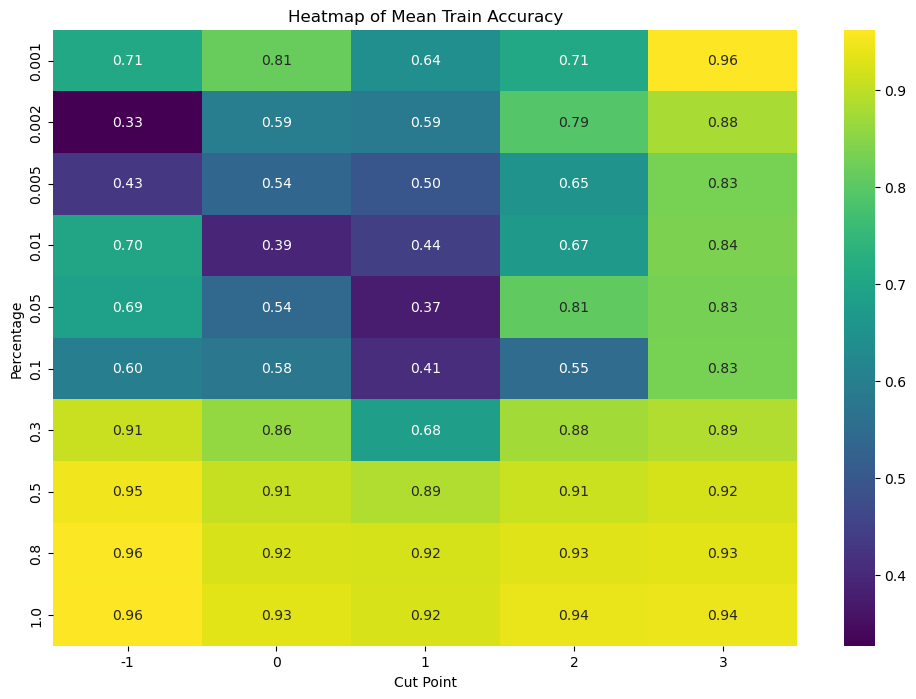

In [17]:
# For the heatmap, we will use the mean test accuracy, aggregated over trials for each combination of 'Percentage' and 'Cut Point'

# We will pivot the dataframe to get the mean test accuracy for each combination of 'Percentage' and 'Cut Point'
heatmap_data = df.pivot_table(index='Percentage', columns='Cut Point', values='Mean Train Accuracy', aggfunc='mean')

# Generating the heatmap using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f")
plt.title('Heatmap of Mean Train Accuracy')
plt.xlabel('Cut Point')
plt.ylabel('Percentage')
plt.show()


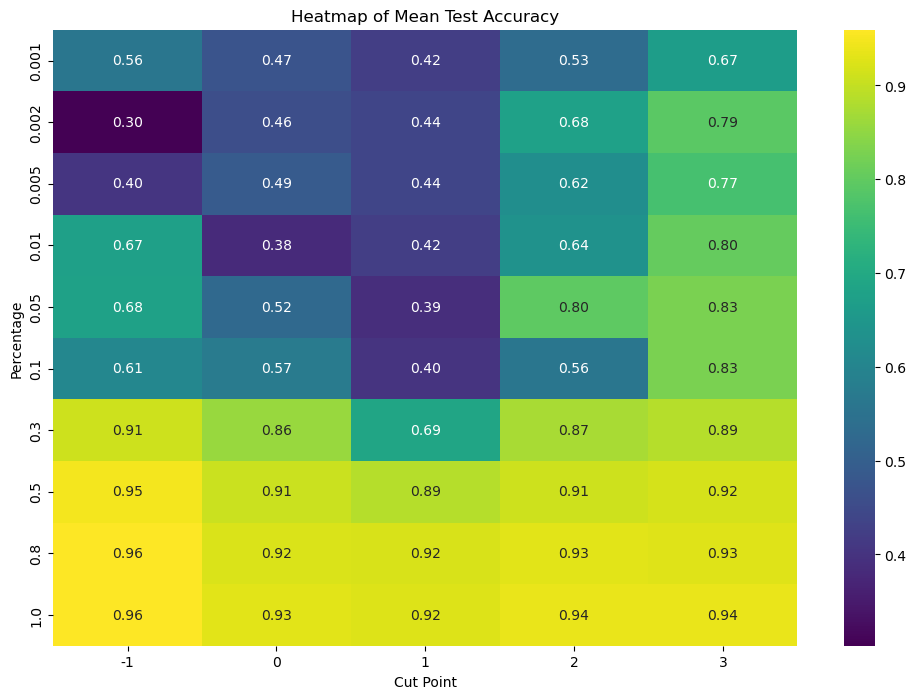

In [18]:
# For the heatmap, we will use the mean test accuracy, aggregated over trials for each combination of 'Percentage' and 'Cut Point'

# We will pivot the dataframe to get the mean test accuracy for each combination of 'Percentage' and 'Cut Point'
heatmap_data = df.pivot_table(index='Percentage', columns='Cut Point', values='Mean Test Accuracy', aggfunc='mean')

# Generating the heatmap using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f")
plt.title('Heatmap of Mean Test Accuracy')
plt.xlabel('Cut Point')
plt.ylabel('Percentage')
plt.show()


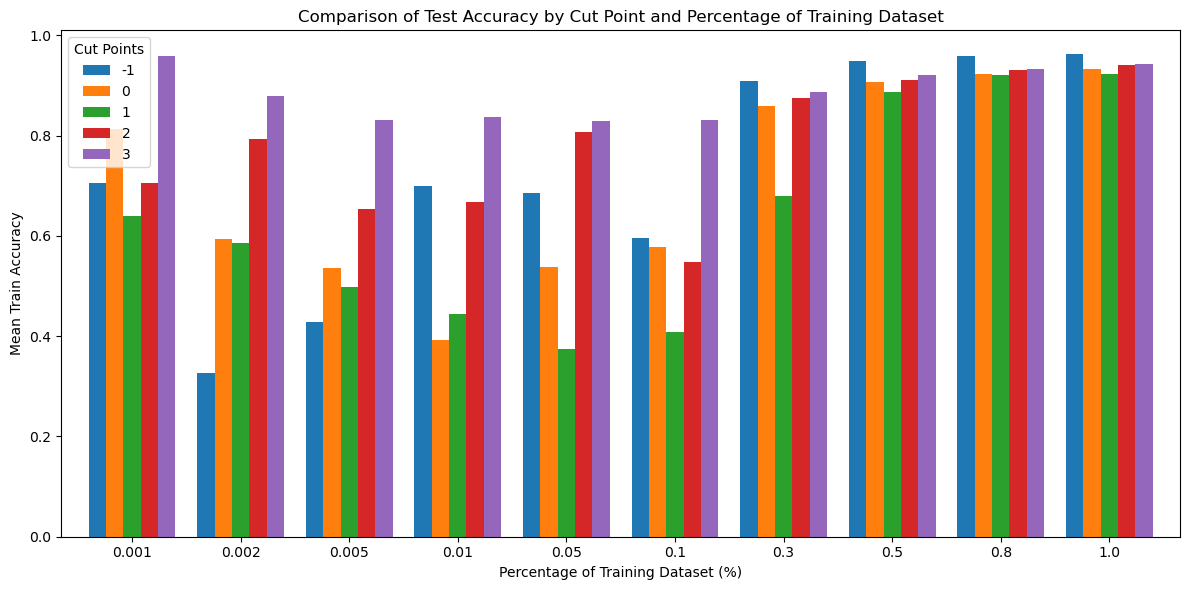

In [19]:
# Create a bar graph for comparing the test accuracies of different cut points at each percentage level.

# Find the mean test accuracy for each cut point at each percentage level.
mean_accuracies = df.groupby(['Cut Point', 'Percentage']).mean()['Mean Train Accuracy'].unstack(0)

# Plotting
mean_accuracies.plot(kind='bar', figsize=(12, 6), width=0.8)

plt.title('Comparison of Test Accuracy by Cut Point and Percentage of Training Dataset')
plt.xlabel('Percentage of Training Dataset (%)')
plt.ylabel('Mean Train Accuracy')
plt.xticks(rotation=0)  # Rotate x-axis labels to show them horizontally.
plt.legend(title='Cut Points')
plt.tight_layout()
plt.show()


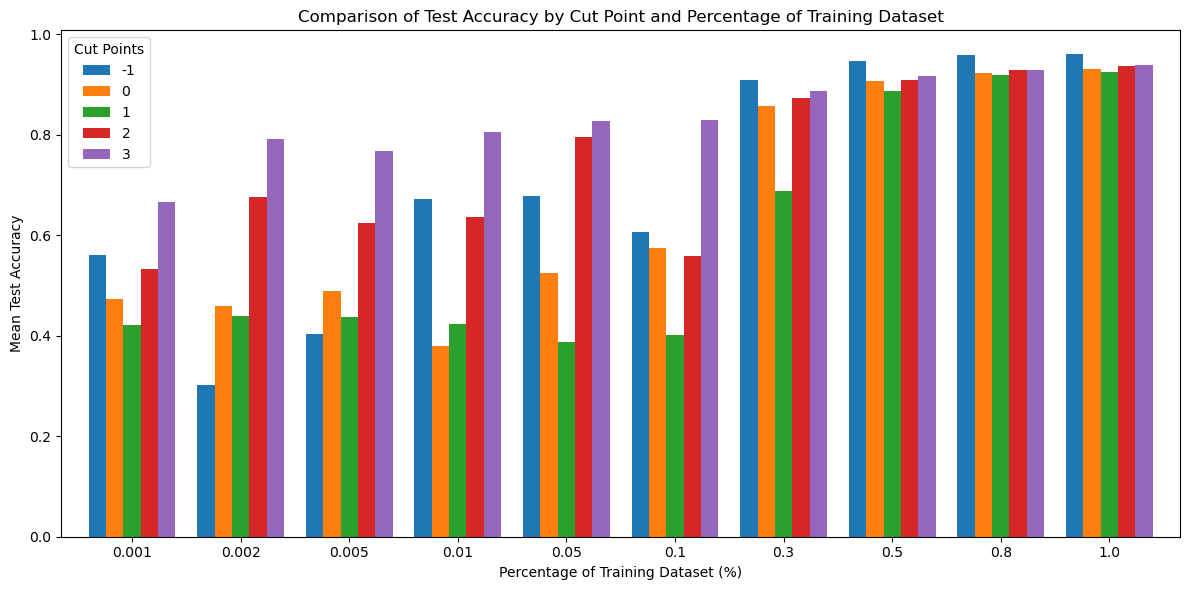

In [20]:
# Create a bar graph for comparing the test accuracies of different cut points at each percentage level.

# Find the mean test accuracy for each cut point at each percentage level.
mean_accuracies = df.groupby(['Cut Point', 'Percentage']).mean()['Mean Test Accuracy'].unstack(0)

# Plotting
mean_accuracies.plot(kind='bar', figsize=(12, 6), width=0.8)

plt.title('Comparison of Test Accuracy by Cut Point and Percentage of Training Dataset')
plt.xlabel('Percentage of Training Dataset (%)')
plt.ylabel('Mean Test Accuracy')
plt.xticks(rotation=0)  # Rotate x-axis labels to show them horizontally.
plt.legend(title='Cut Points')
plt.tight_layout()
plt.show()


### Compare to Baseline End-to-end Models
Skip this one for now

In [111]:
params["lr"] = 0.001
dataloader_wrapped.update_phase('finetune')

baseline_results = []

for sampled_percentage in percentages:
    # Create DNN model
    baseline_model = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
                        hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=params['use_pooling'])
    baseline_model.to(device)

    # Reduce the dataset
    train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed=random.randint(0, 100))
    dataset_namespace_new = SimpleNamespace(train_loader=train_loader_reduced, test_loader=dataloader_wrapped.test_loader, val_loader=dataloader_wrapped.val_loader)

    # Train and evaluate
    trainer = Trainer(baseline_model, dataset_namespace_new, params)
    train_acc, test_acc, effective_epochs, checkpoints = trainer.train(verbose=0)
    print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

    # Store the results
    baseline_results.append((sampled_percentage, repeat, train_acc, test_acc))

print(baseline_results)

# first of all convert results to df and calculate the mean and std of repats
repeats_mean = []
i = 0
for sampled_percentage in percentages:
    train, test = [], []
    for repeat in range(repeats):
        train.append(results[i][3])
        test.append(results[i][4])
        i += 1
    repeats_mean.append((sampled_percentage, np.mean(train), np.std(train), np.mean(test), np.std(test)))
df_baseline = pd.DataFrame(results, columns=['Percentage', 'Mean Train Accuracy', 'Std Train Accuracy', 'Mean Test Accuracy', 'Std Test Accuracy'])
df_baseline

KeyboardInterrupt: ignored